# Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Data Loading

In [2]:
base_dir='input'
class_labels=os.listdir(base_dir)
class_labels.sort()
print(class_labels)

['covid', 'normal']


In [3]:
data=[]
labels=[]
count=0
for target in class_labels:
    path=os.path.join(base_dir,target)
    print(f'Images loading from {path}')
    image_names=os.listdir(path)
    for image_name in tqdm(image_names):
        image_path=os.path.join(path,image_name)
        image=cv2.imread(image_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,(128,128))
        image=np.array(image)
        image=image/255.0
        data.append(image)
        labels.append(count)
    count+=1

Images loading from input\covid


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.05it/s]


Images loading from input\normal


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.83it/s]


In [4]:
data=np.array(data)
labels=np.array(labels)

print(data.shape,labels.shape)

(2000, 128, 128, 3) (2000,)


In [5]:
y=to_categorical(labels)
X_train,X_test,y_train,y_test=train_test_split(data,y,test_size=0.2,random_state=42,shuffle=True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1600, 128, 128, 3) (400, 128, 128, 3) (1600, 2) (400, 2)


In [6]:
from random import randint
def show_images(X,y,class_names):
    Y=np.argmax(y,axis=1)
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        idx = randint(0, X.shape[0]-1)
        plt.imshow(X[idx])
        plt.axis("off")
        plt.title("Class:{}".format(class_names[Y[idx]]))
    plt.tight_layout()
    plt.show()

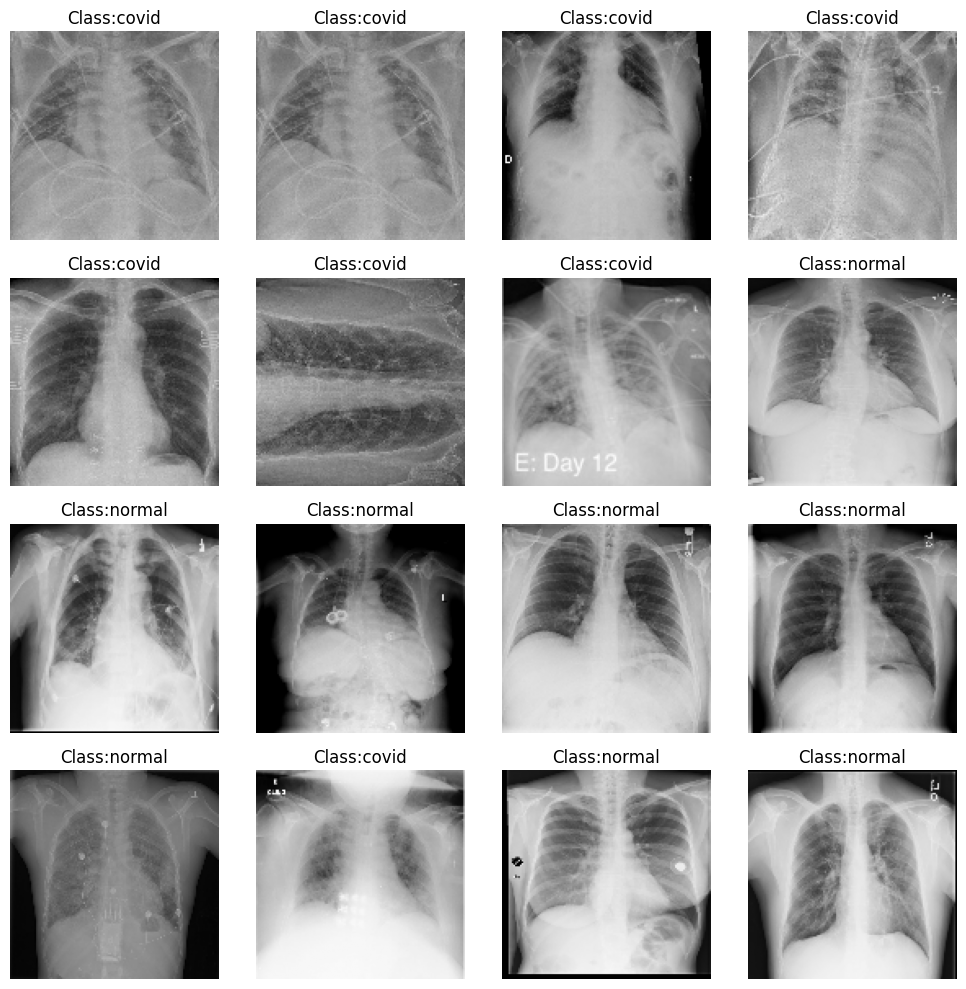

In [7]:
show_images(X_train,y_train,class_labels)

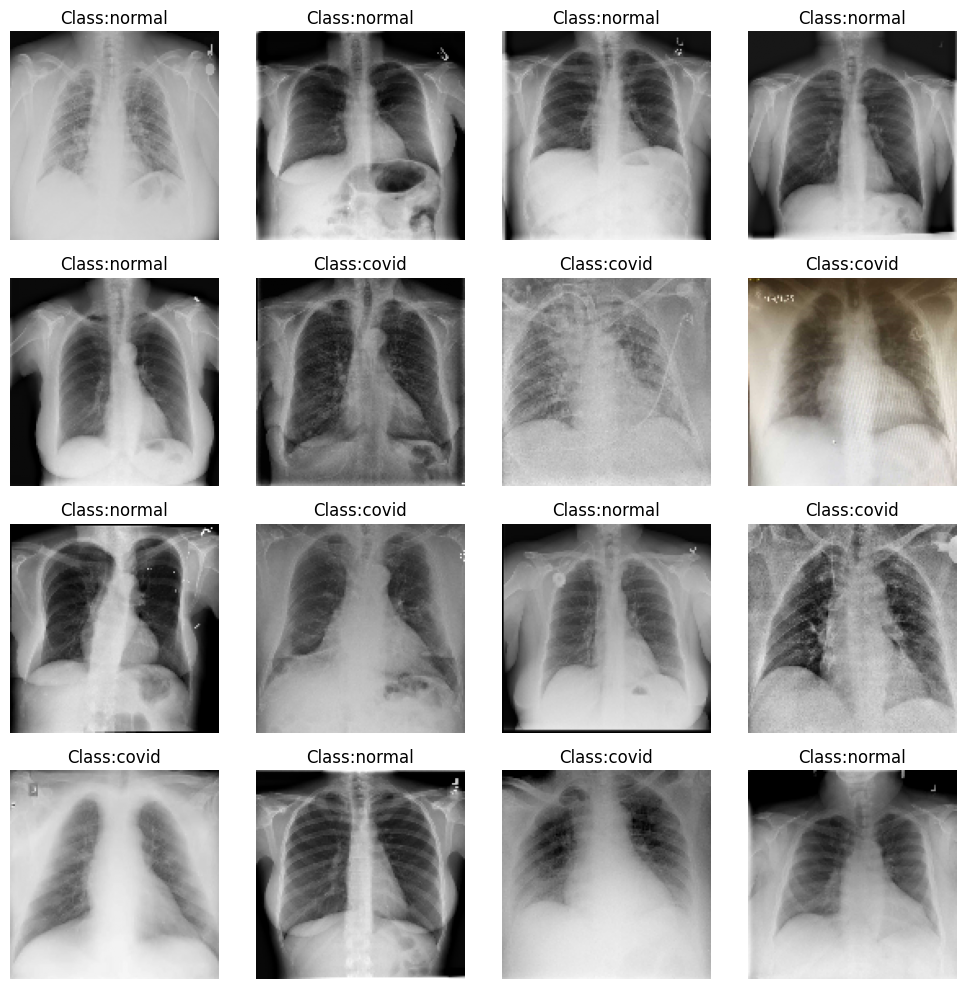

In [8]:
show_images(X_test,y_test,class_labels)

In [9]:
vgg_model=tf.keras.applications.VGG16(include_top=False,
                                      weights="imagenet",
                                      input_tensor=None,
                                      input_shape=(128,128,3),
                                      pooling="max",
                                      classes=1000)
vgg_model.trainable = False

In [10]:
inputs = vgg_model.input
fc1 = tf.keras.layers.Dense(512, activation='relu')(vgg_model.output)
fc1 = tf.keras.layers.Dropout(rate=0.5)(fc1)
fc2 = tf.keras.layers.Dense(len(class_labels), activation='softmax')(fc1)
vgg_model = tf.keras.Model(inputs=inputs, outputs=fc2)
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [11]:
number_of_epochs=30
history=vgg_model.fit(x=X_train,y=y_train,batch_size=64,epochs=number_of_epochs,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/30
25/25 [==============================] - 516s 21s/step - loss: 0.5895 - accuracy: 0.7063 - val_loss: 0.3186 - val_accuracy: 0.8550
Epoch 2/30
25/25 [==============================] - 620s 25s/step - loss: 0.3000 - accuracy: 0.8700 - val_loss: 0.2139 - val_accuracy: 0.9050
Epoch 3/30
25/25 [==============================] - 626s 25s/step - loss: 0.2301 - accuracy: 0.9019 - val_loss: 0.2058 - val_accuracy: 0.9250
Epoch 4/30
25/25 [==============================] - 604s 24s/step - loss: 0.2096 - accuracy: 0.9125 - val_loss: 0.1931 - val_accuracy: 0.9300
Epoch 5/30
25/25 [==============================] - 621s 25s/step - loss: 0.1957 - accuracy: 0.9212 - val_loss: 0.1869 - val_accuracy: 0.9225
Epoch 6/30
25/25 [==============================] - 404s 16s/step - loss: 0.1698 - accuracy: 0.9356 - val_loss: 0.1873 - val_accuracy: 0.9250
Epoch 7/30
25/25 [==============================] - 162s 7s/step - loss: 0.1551 - accuracy: 0.9469 - val_loss: 0.1757 - val_accuracy: 0.9275
Epoch 8

### Accuracy and Loss plot-graphs

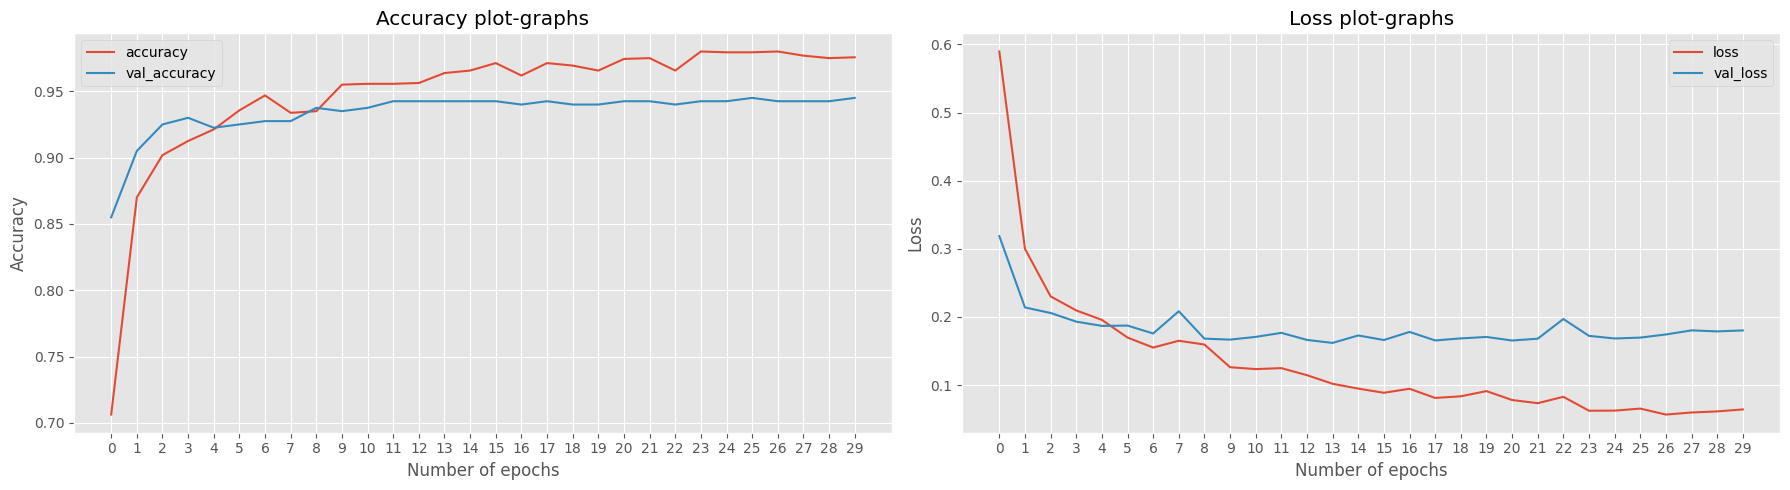

In [12]:
with plt.style.context(style='ggplot'):
    fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    axes[0].plot(history.history["accuracy"],label="accuracy")
    axes[0].plot(history.history["val_accuracy"],label="val_accuracy")
    axes[0].set_title(label='Accuracy plot-graphs')
    axes[0].set_xlabel(xlabel='Number of epochs')
    axes[0].set_ylabel(ylabel='Accuracy')
    axes[0].set_xticks(range(number_of_epochs))
    axes[0].legend()
    axes[1].plot(history.history["loss"],label="loss")
    axes[1].plot(history.history["val_loss"],label="val_loss")
    axes[1].set_title(label='Loss plot-graphs')
    axes[1].set_xlabel(xlabel='Number of epochs')
    axes[1].set_ylabel(ylabel='Loss')
    axes[1].set_xticks(range(number_of_epochs))
    axes[1].legend()
    fig.tight_layout()
    plt.show()

In [13]:
model_pred=vgg_model.predict(X_test,batch_size=32,verbose=1)

13/13 [==============================] - 40s 3s/step


In [14]:
print(model_pred)

[[2.08943710e-01 7.91056335e-01]
 [2.53780599e-04 9.99746263e-01]
 [8.77887651e-04 9.99122083e-01]
 [9.72078502e-01 2.79215202e-02]
 [1.70480882e-06 9.99998331e-01]
 [1.32394489e-04 9.99867558e-01]
 [9.99959588e-01 4.04621678e-05]
 [1.90256292e-03 9.98097479e-01]
 [8.35221171e-01 1.64778829e-01]
 [3.51234287e-01 6.48765683e-01]
 [9.99882102e-01 1.17859170e-04]
 [2.08395097e-04 9.99791563e-01]
 [2.75409606e-04 9.99724567e-01]
 [9.89688396e-01 1.03115896e-02]
 [9.92414653e-01 7.58538209e-03]
 [9.99791086e-01 2.08946643e-04]
 [1.02864862e-04 9.99897122e-01]
 [9.97317612e-01 2.68242415e-03]
 [1.04083236e-04 9.99895930e-01]
 [1.52502896e-03 9.98475015e-01]
 [9.99996424e-01 3.63580534e-06]
 [7.03485403e-03 9.92965102e-01]
 [1.54941957e-02 9.84505832e-01]
 [9.74506419e-03 9.90254939e-01]
 [3.68587353e-04 9.99631405e-01]
 [9.95295942e-01 4.70404606e-03]
 [4.69784536e-05 9.99953032e-01]
 [9.56090927e-01 4.39091027e-02]
 [9.89682138e-01 1.03178881e-02]
 [9.99953747e-01 4.62948119e-05]
 [9.999997

In [15]:
model_labels=[]
for i in range(len(model_pred)):
    model_labels.append(np.argmax(model_pred[i]))

In [16]:
print(model_labels)

[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 

In [17]:
true_labels=[]
for i in range(len(y_test)):
    true_labels.append(np.argmax(y_test[i]))

In [18]:
print(true_labels)

[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 

### Result Analysis

***Accuracy Score***

In [19]:
model_accuracy=accuracy_score(y_true=true_labels,y_pred=model_labels)
print(f"Validation accuracy of VGG16 model accuracy is {model_accuracy*100.0:.2f}%")

Validation accuracy of VGG16 model accuracy is 94.50%


***Classification Report***

In [20]:
from IPython.core.display import display,HTML
display(HTML("<h1>VGG16 model classification report"))
print(classification_report(y_true=true_labels,y_pred=model_labels,target_names=class_labels))

              precision    recall  f1-score   support

       covid       0.94      0.94      0.94       199
      normal       0.95      0.95      0.95       201

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



***Confusion Matrix***

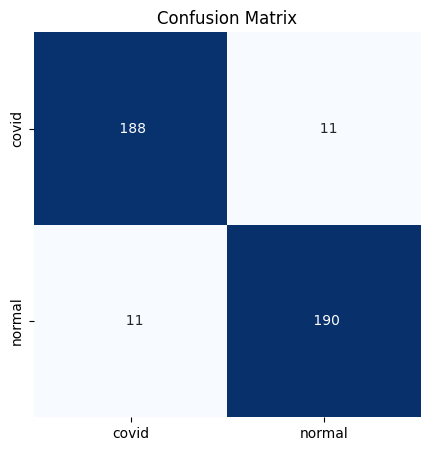

In [21]:
plt.figure(figsize=(5,5))
sns.heatmap(data=confusion_matrix(y_true=true_labels,y_pred=model_labels),
            annot=True,
            fmt='4d',
            cbar=False,
            cmap=plt.cm.Blues,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title(label='Confusion Matrix')
plt.show()

***Model Saving***

In [22]:
vgg_model.save(filepath="models/VGG16_model.h5")